In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2

import warnings
warnings.simplefilter(action='ignore')

import pandas as pd
import platform

# Import matplotlib libraries
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import time

2024-08-22 18:43:42.407033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 18:43:42.431456: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 18:43:42.431484: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-22 18:43:42.445139: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-22 18:43:43.431352: W tensorflow/compiler/tf

In [2]:
if platform.system() == "Darwin":
    root_directory = '/Users/lorenzobarbiero/Documents/GitHub/human_pose'
    data_directory = '/Users/lorenzobarbiero/Desktop/Università/VCS/Human Action Recognition'
else:
    root_directory = ''
    data_directory = '../human_pose_local/archive/Human Action Recognition'

print('root directory is ' + root_directory)
print('data directory is ' + data_directory)

root directory is 
data directory is ../human_pose_local/archive/Human Action Recognition


### Load the data

In [3]:
# file_name = 'movenet_thunder_mobilenet_small'
# file_name = 'movenet_lightning_mobilenet_large'
# file_name = 'movenet_thunder_mobilenet_large'
# file_name = 'movenet_lightning_mobilenet_small'

In [4]:
file_name = "movenet_thunder_mobilenet_large"

In [5]:
df = pd.read_pickle(data_directory + '/' + file_name + '.pkl')

In [6]:
# apply the function to the dataframe
df['keypoints'] = df['keypoints'].apply(lambda x: np.array(x))
df['object'] = df['object'].apply(lambda x: np.array(x).reshape(-1, 1))
df['obj_vector'] = df['obj_vector'].apply(lambda x: np.array(x))
df['category'] = df['category'].apply(lambda x: np.array(x))

In [7]:
# shape of the data
print('keypoints shape: ', df['keypoints'].iloc[0].shape)
print('object shape: ', df['object'].iloc[0].shape)
print('obj_vector shape: ', df['obj_vector'].iloc[0].shape)

keypoints shape:  (51,)
object shape:  (5, 1)
obj_vector shape:  (5, 100)


In [8]:
# set to 0 the keypoints with score < 0.3
def filter_keypoints(x):
    x[x[:, 2] < 0.3] = 0
    return x

# df['keypoints'] = df['keypoints'].apply(lambda x: filter_keypoints(x))

# keep only the positions of the keypoints
def get_positions(x):
    return x[:, :2]

# df['keypoints'] = df['keypoints'].apply(lambda x: get_positions(x))

# set to 0 the object with score < 0.1
def filter_object(x):
    x[x[:, 0] < 0.1] = 0
    return x

# df['object'] = df['object'].apply(lambda x: filter_object(x))

In [9]:
# number of object to consider
n_objects = 5

In [10]:
df['obj_input'] = df.apply(lambda x: np.sum(x['object'][-n_objects:]
                                            *x['obj_vector'][-n_objects:], axis=0), axis=1)
df['keypoints'] = df['keypoints'].apply(lambda x: x.flatten())

In [11]:
df

,filename,label,category,keypoints,object,obj_label,obj_vector,obj_words,obj_input
0,Image_1.jpg,sitting,11,"[0.0882076621055603, 0.6247615814208984, 0.756...","[[0.60480165], [0.04718776], [0.032203343], [0...","[697, 789, 822, 514, 614]","[[-0.28338998556137085, 0.4774399995803833, 0....","[[pajama], [shoji], [steel, drum], [cowboy, bo...","[-0.20592125285495, 0.3260203410991888, -0.008..."
1,Image_2.jpg,using_laptop,14,"[0.30178800225257874, 0.9912914037704468, 0.80...","[[0.7418762], [0.040941585], [0.012892539], [0...","[831, 416, 669, 697, 681]","[[0.3403800129890442, -0.9357600212097168, 1.1...","[[studio, couch], [balance, beam], [mosquito, ...","[0.2683790374652541, -0.6670002713657828, 0.87..."
2,Image_3.jpg,hugging,7,"[0.20708897709846497, 0.6019015908241272, 0.42...","[[0.1416007], [0.13604547], [0.05453948], [0.0...","[697, 522, 984, 529, 416]","[[-0.28338998556137085, 0.4774399995803833, 0....","[[pajama], [croquet, ball], [rapeseed], [diape...","[-0.02030288063444885, 0.23200371996866265, 0...."
3,Image_4.jpg,sleeping,12,"[0.37268558144569397, 0.1374012678861618, 0.20...","[[0.6505104], [0.06191667], [0.027490702], [0....","[678, 691, 680, 529, 823]","[[-1.2170699834823608, -0.12339100241661072, -...","[[neck, brace], [oxygen, mask], [nipple], [dia...","[-0.8215984234954313, -0.02994576481942718, -0..."
4,Image_5.jpg,using_laptop,14,"[0.03276867792010307, 0.2222181260585785, 0.79...","[[0.71057284], [0.10088889], [0.035408325], [0...","[490, 655, 689, 824, 601]","[[-0.1615300178527832, -0.205020010471344, -0....","[[chain, mail], [miniskirt], [overskirt], [sto...","[-0.1494515264241883, -0.1284101833971808, -0...."
...,...,...,...,...,...,...,...,...,...
12595,Image_12596.jpg,sitting,11,"[0.04209192469716072, 0.7099579572677612, 0.58...","[[0.23895389], [0.14317973], [0.076097175], [0...","[706, 905, 624, 559, 831]","[[-0.399260014295578, 0.13120000064373016, -0....","[[patio], [window, shade], [library], [folding...","[-0.14739882579379793, 0.2794763101199509, -0...."
12596,Image_12597.jpg,clapping,1,"[0.06415694206953049, 0.705790638923645, 0.468...","[[0.8603377], [0.021510318], [0.016789775], [0...","[617, 823, 678, 904, 905]","[[0.10435998439788818, 0.29162999987602234, 0....","[[lab, coat], [stethoscope], [neck, brace], [w...","[0.057619909586660134, 0.26067134955875726, 0...."
12597,Image_12598.jpg,sitting,11,"[0.051420778036117554, 0.4904737174510956, 0.5...","[[0.48068434], [0.07919033], [0.043129846], [0...","[608, 743, 843, 487, 543]","[[-0.13323000073432922, -0.6275100111961365, -...","[[jean], [prison], [swing], [cellular, telepho...","[-0.001942008389194727, -0.2787240437545768, -..."
12598,Image_12599.jpg,dancing,3,"[0.2283279001712799, 0.42992380261421204, 0.62...","[[0.15199172], [0.068358354], [0.059058633], [...","[416, 615, 747, 617, 587]","[[0.5044400095939636, 0.536300003528595, -0.07...","[[balance, beam], [knee, pad], [punching, bag]...","[0.014005273690095521, 0.06621338508228547, -0..."


### Training-Test split

In [12]:
def train_test_split_df(df, test_perc): 

    n_classes = df['category'].nunique()
    n_samples = int(len(df)*test_perc/n_classes)
    test_df = df.groupby('category').apply(lambda x: x.sample(n_samples)).reset_index(drop=True)

    # split the dataframe in train and test by the column 'filename'
    train_df = df[~df['filename'].isin(test_df['filename'])]

    return train_df, test_df

In [13]:
train_df, test_df = train_test_split_df(df, 0.2)

### Tensorflow Dataset

In [14]:
def create_dataset(df, batch_size, use_object=True, use_keypoints=True):
    
    labels = df['category']
    
    kpoints = df['keypoints']

    if use_object and use_keypoints:
        df['input'] = df.apply(lambda x: np.concatenate((x['keypoints'], x['obj_input'])), axis=1)
    elif use_keypoints:
        df['input'] = df['keypoints']
    elif use_object:
        df['input'] = df['obj_input']
    else:
        print('error: no input selected')
        return
    
    input_shape = df['input'].iloc[0].shape

    data = np.zeros((len(kpoints), input_shape[0]), dtype=np.float32)
    
    for i, row in enumerate(df['input']): 
        data[i,:] = np.array(row).astype(np.float32)
        
    dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    
    dataset = dataset.batch(batch_size = batch_size)
    
    return dataset, input_shape

### Define the model

In [15]:
#BEST ONE
def create_model(input_shape, summary=False):
    
    model = tf.keras.Sequential([
            tf.keras.Input(shape=input_shape),
            tf.keras.layers.Dense(128, activation='leaky_relu'),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(64, activation='leaky_relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(64, activation='leaky_relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32, activation='leaky_relu'),
            tf.keras.layers.Dense(32, activation='leaky_relu'),
            tf.keras.layers.Dense(15, activation='softmax')
        ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    if summary:
        model.summary()
    
    return model

In [16]:
model = create_model((1,), summary=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 15)             │           495 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,303 (63.68 KB)

 Trainable params: 16,303 (63.68 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
def plot_train(results):
    
    train_loss = results.history['loss']
    val_loss = results.history['val_loss']
    train_accuracy = results.history['accuracy']
    val_accuracy = results.history['val_accuracy']
    
    t = np.arange(len(train_accuracy))
    
    print('Stopped at epoch ', len(train_accuracy))
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))

    ax1.plot(t, train_loss, 'b')
    ax1.set_title('Train loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')

    ax2.plot(t, val_loss, 'g')
    ax2.set_title('Validation loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')

    ax3.plot(t, train_accuracy, 'b')
    ax3.set_title('Training accuracy')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Accuracy')

    ax4.plot(t, val_accuracy, 'g')
    ax4.set_title('Validation accuracy')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Accuracy')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Display the plot
    plt.show()

In [18]:
use_object = True
use_keypoints = True

Starting Fold Number  1

Fitting the model:

Training time:  40.18  s
Stopped at epoch  83


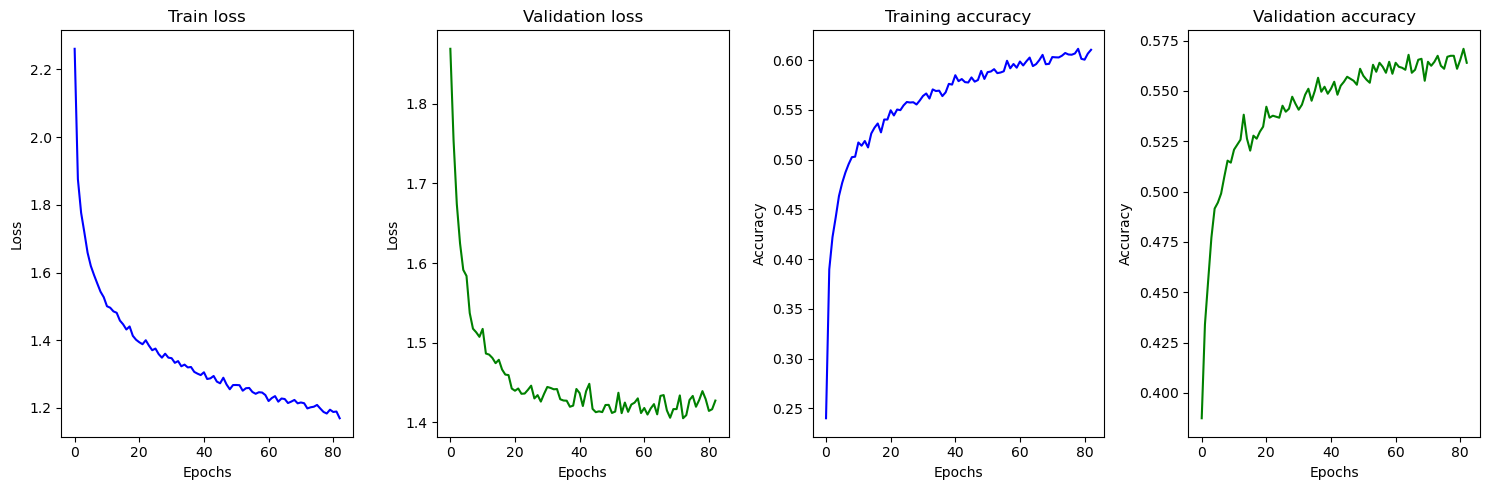

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5555 - loss: 1.4475

-----------------------------------------------------------------

Starting Fold Number  2



2024-08-22 18:44:28.589512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Fitting the model:

Training time:  25.28  s
Stopped at epoch  44


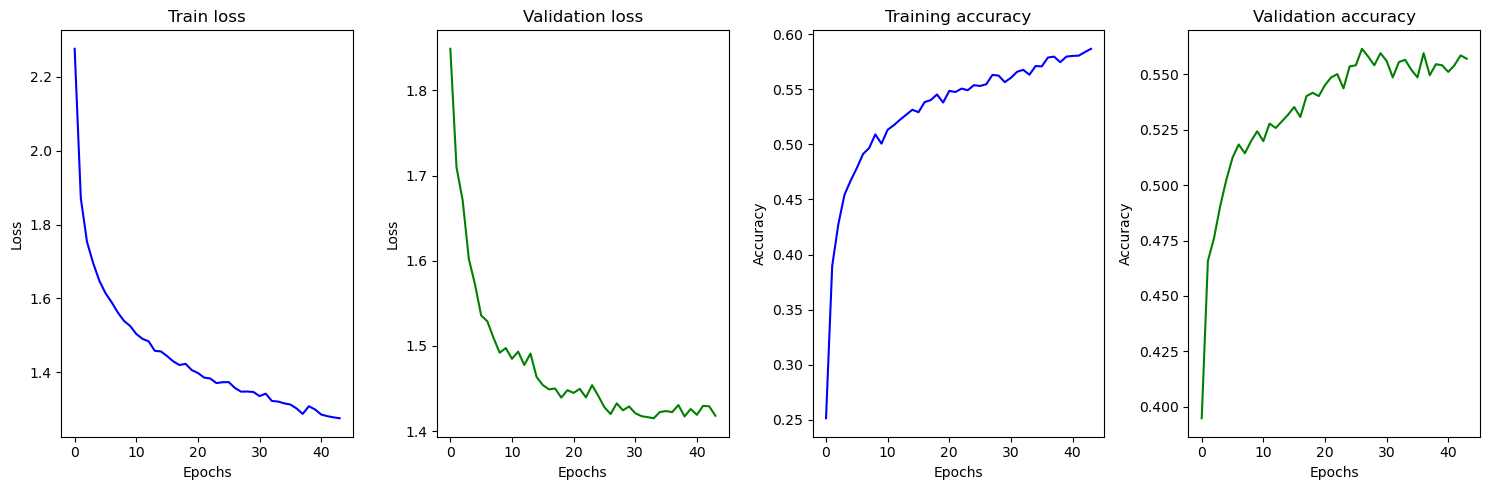

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5494 - loss: 1.4513

-----------------------------------------------------------------

Starting Fold Number  3



2024-08-22 18:44:54.903809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Fitting the model:

Training time:  34.62  s
Stopped at epoch  78


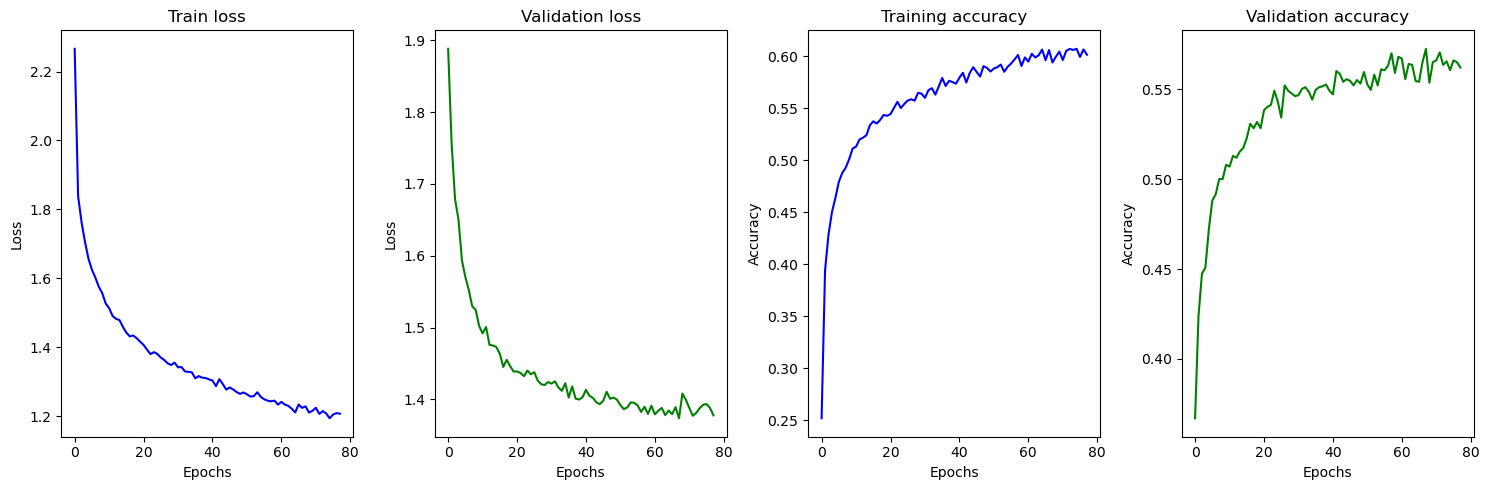

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - accuracy: 0.5424 - loss: 1.4262

-----------------------------------------------------------------

Starting Fold Number  4



2024-08-22 18:45:30.355953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Fitting the model:

Training time:  24.76  s
Stopped at epoch  56


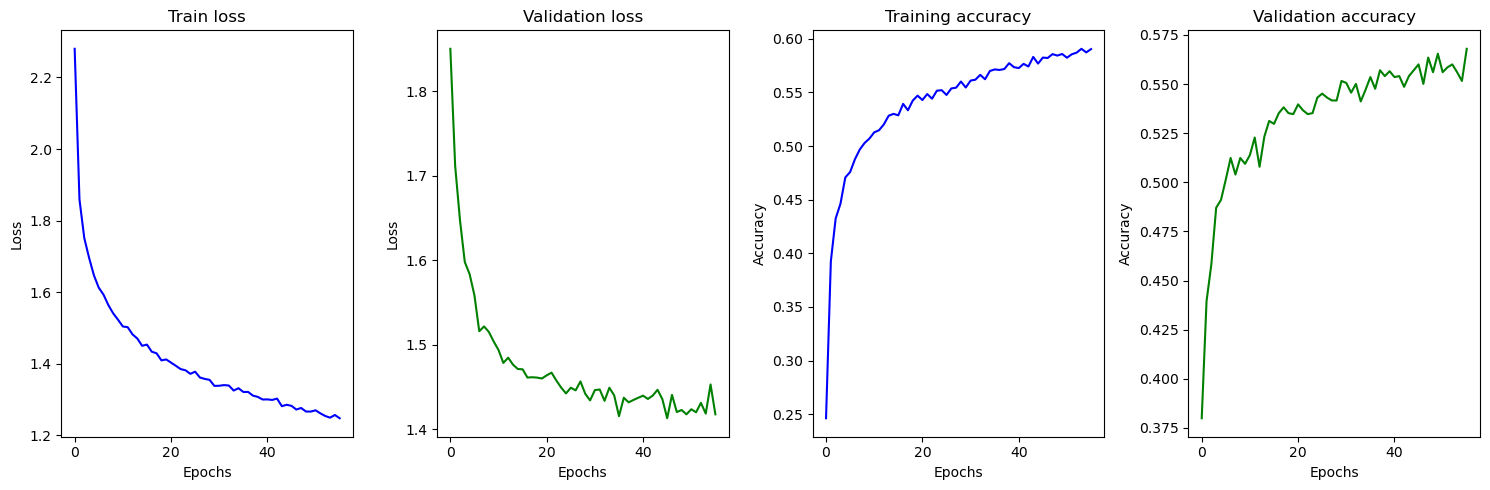

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.5656 - loss: 1.4183

-----------------------------------------------------------------

Starting Fold Number  5



2024-08-22 18:45:55.982946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Fitting the model:

Training time:  26.48  s
Stopped at epoch  61


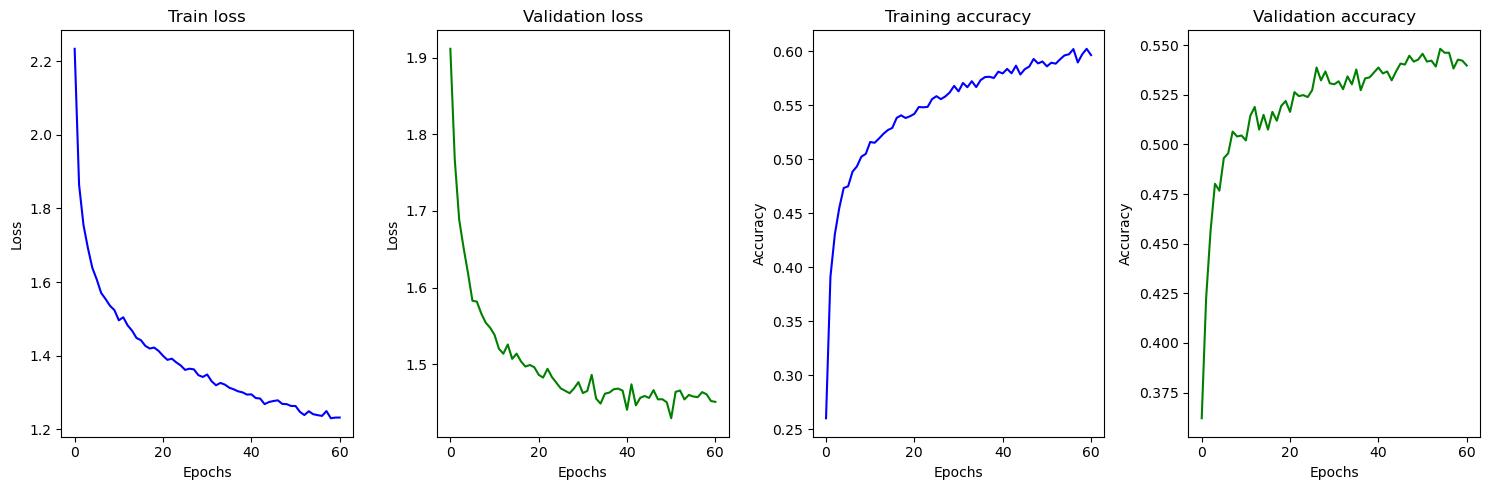

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.5561 - loss: 1.4081

-----------------------------------------------------------------



2024-08-22 18:46:23.244290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [19]:
# Number of folds
n_splits = 5
batch_s = 32
index = 1

# KFold cross-validation
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

accuracy_per_fold = []
conf_matrix = np.zeros((15,15))

epochs_per_fold = []

for train_index, val_index in kf.split(train_df):
    
    print("Starting Fold Number ", index)
    print()
    
    index += 1      
    
    df_train, df_val = train_df.iloc[train_index], train_df.iloc[val_index]
    
    # Convert to TensorFlow datasets
    train_dataset, inp_shape = create_dataset(df_train, batch_s, use_keypoints=use_keypoints, use_object=use_object)
    val_dataset, _ = create_dataset(df_val, batch_s, use_keypoints=use_keypoints, use_object=use_object)
    
    print("Fitting the model:")
    print()
    
    start = time.time()
    
    # Create a new instance of the model
    model = create_model(input_shape=inp_shape)
    
    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

    results = model.fit(train_dataset,
                        epochs=1000,
                        validation_data=val_dataset, 
                        callbacks=[early_stop_callback], verbose = 0)
    
    epochs = len(results.history['loss'])
    epochs_per_fold.append(epochs)

    end = time.time()
    print('Training time: ', round(end-start,2), " s")
    
    plot_train(results)
    
    # compute predicted labels
    output_vector = model.predict(val_dataset)
    predicted_labels = np.argmax(output_vector[:,:], axis=1)

    extracted_labels = []
    for _, label in val_dataset:
        extracted_labels.extend(label.numpy().tolist())

    true_labels = np.array(extracted_labels)
    
    # compute the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    #print(cm)
    conf_matrix = conf_matrix + cm
    
    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(val_dataset)
    accuracy_per_fold.append(val_accuracy)
    
    print()
    print('-----------------------------------------------------------------')
    print()

avg_epochs = np.mean(epochs_per_fold)

### Analyze the results

In [20]:
# get the label from the category
labels = df.groupby('category').first()['label']
labels = np.array(labels).tolist()
labels[9] = 'music'

In [21]:
# Define a function to plot the confusion matrix
def plot_confusion_matrix(cm, threshold=0.1):
    #normalize cm
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(11, 6))
    ax = sns.heatmap(cm_normalized, annot=False, cmap='Greens', vmin=0, vmax=1, cbar=True, xticklabels=labels, yticklabels=labels)
    
    # Annotate only the main diagonal with rounded values
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i == j or cm_normalized[i, j] > threshold:
                if cm_normalized[i, j] < 0.7:
                    ax.text(j + 0.5, i + 0.5, f'{cm_normalized[i, j]:.2f}', 
                            ha='center', va='center', color='black', fontsize=14)
                else:
                    ax.text(j + 0.5, i + 0.5, f'{cm_normalized[i, j]:.2f}', 
                            ha='center', va='center', color='white', fontsize=14)    
                
    # Labels, title and axes
    ax.set_title("Neural Network")
    ax.set_xlabel('Predicted labels', fontsize = 14)
    ax.set_ylabel('True labels', fontsize = 14)
    plt.xticks(rotation=60)
    
    plt.show()

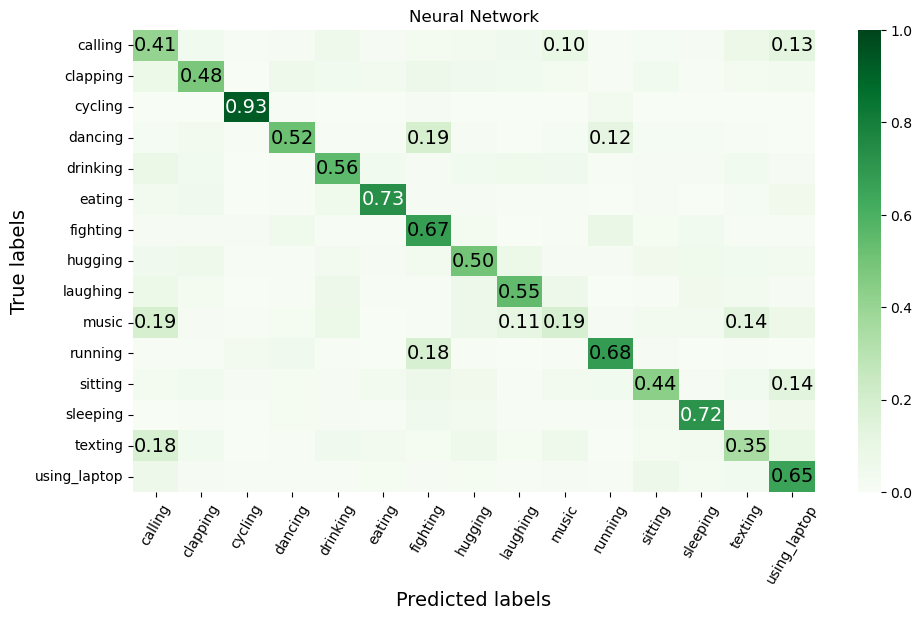

In [22]:
plot_confusion_matrix(conf_matrix)

In [23]:
def class_specific_metrics(cm, class_labels = labels):
    # Compute the confusion matrix

    # Initialize dictionaries to hold metrics for each class
    accuracy = {}
    sensitivity = {}
    specificity = {}
    precision = {}

    for idx, label in enumerate(class_labels):
        # True positives
        TP = cm[idx, idx]

        # False positives
        FP = cm[:, idx].sum() - TP

        # False negatives
        FN = cm[idx, :].sum() - TP

        # True negatives
        TN = cm.sum() - (TP + FP + FN)

        # Calculate metrics
        accuracy[label] = (TP + TN) / cm.sum()
        sensitivity[label] = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity[label] = TN / (TN + FP) if (TN + FP) != 0 else 0
        precision[label] = TP / (TP + FP) if (TP + FP) != 0 else 0

    metrics_dict = {label: {'Accuracy': accuracy[label],
                        'Sensitivity': sensitivity[label],
                        'Specificity': specificity[label],
                        'Precision': precision[label]}
                    for label in class_labels}

    # Convert the dictionary to a pandas DataFrame
    df_metrics = pd.DataFrame.from_dict(metrics_dict, orient='index')
    df_metrics

    return df_metrics

In [24]:
val_metrics = class_specific_metrics(conf_matrix)
val_metrics

,Accuracy,Sensitivity,Specificity,Precision
calling,0.904167,0.409226,0.939520,0.325829
clapping,0.937897,0.480655,0.970557,0.538333
cycling,0.988591,0.927083,0.992985,0.904209
dancing,0.947817,0.520833,0.978316,0.631769
drinking,0.941071,0.555060,0.968644,0.558383
eating,0.965774,0.730655,0.982568,0.749618
fighting,0.930258,0.672619,0.948661,0.483422
hugging,0.933135,0.500000,0.964073,0.498516
laughing,0.942659,0.546131,0.970982,0.573438
music,0.917560,0.190476,0.969494,0.308434


In [25]:
train_df

,filename,label,category,keypoints,object,obj_label,obj_vector,obj_words,obj_input
0,Image_1.jpg,sitting,11,"[0.0882076621055603, 0.6247615814208984, 0.756...","[[0.60480165], [0.04718776], [0.032203343], [0...","[697, 789, 822, 514, 614]","[[-0.28338998556137085, 0.4774399995803833, 0....","[[pajama], [shoji], [steel, drum], [cowboy, bo...","[-0.20592125285495, 0.3260203410991888, -0.008..."
2,Image_3.jpg,hugging,7,"[0.20708897709846497, 0.6019015908241272, 0.42...","[[0.1416007], [0.13604547], [0.05453948], [0.0...","[697, 522, 984, 529, 416]","[[-0.28338998556137085, 0.4774399995803833, 0....","[[pajama], [croquet, ball], [rapeseed], [diape...","[-0.02030288063444885, 0.23200371996866265, 0...."
3,Image_4.jpg,sleeping,12,"[0.37268558144569397, 0.1374012678861618, 0.20...","[[0.6505104], [0.06191667], [0.027490702], [0....","[678, 691, 680, 529, 823]","[[-1.2170699834823608, -0.12339100241661072, -...","[[neck, brace], [oxygen, mask], [nipple], [dia...","[-0.8215984234954313, -0.02994576481942718, -0..."
4,Image_5.jpg,using_laptop,14,"[0.03276867792010307, 0.2222181260585785, 0.79...","[[0.71057284], [0.10088889], [0.035408325], [0...","[490, 655, 689, 824, 601]","[[-0.1615300178527832, -0.205020010471344, -0....","[[chain, mail], [miniskirt], [overskirt], [sto...","[-0.1494515264241883, -0.1284101833971808, -0...."
5,Image_6.jpg,sleeping,12,"[0.5809446573257446, 0.0698910802602768, 0.475...","[[0.42156386], [0.07435682], [0.035931084], [0...","[529, 797, 639, 680, 830]","[[-0.3597100079059601, 0.323419988155365, -0.0...","[[diaper], [sleeping, bag], [maillot], [nipple...","[-0.13262058044373626, 0.16139265389794805, -0..."
...,...,...,...,...,...,...,...,...,...
12591,Image_12592.jpg,using_laptop,14,"[0.15719932317733765, 0.8774964809417725, 0.04...","[[0.6999493], [0.115890324], [0.048762597], [0...","[681, 620, 590, 782, 810]","[[-0.43801000714302063, 0.4957199990749359, 1....","[[notebook], [laptop], [hand, held, computer],...","[-0.3639200446912717, 0.3886973744411481, 0.89..."
12592,Image_12593.jpg,clapping,1,"[0.11721930652856827, 0.5230600833892822, 0.46...","[[0.12592044], [0.057747457], [0.047292523], [...","[865, 788, 638, 860, 837]","[[0.5181999802589417, -0.48190000653266907, -0...","[[toyshop], [shoe, shop], [maillot], [tobacco,...","[0.21049223974022868, -0.09453885051950989, -0..."
12593,Image_12594.jpg,sleeping,12,"[0.5327059030532837, 0.9235860705375671, 0.221...","[[0.50943524], [0.05726609], [0.040333997], [0...","[452, 431, 516, 824, 750]","[[-0.9582499861717224, -0.7145000100135803, -0...","[[bonnet], [bassinet], [cradle], [stole], [qui...","[-0.4324512449262139, -0.3117609527811183, -0...."
12596,Image_12597.jpg,clapping,1,"[0.06415694206953049, 0.705790638923645, 0.468...","[[0.8603377], [0.021510318], [0.016789775], [0...","[617, 823, 678, 904, 905]","[[0.10435998439788818, 0.29162999987602234, 0....","[[lab, coat], [stethoscope], [neck, brace], [w...","[0.057619909586660134, 0.26067134955875726, 0...."


### Fit of the selected model on the training set

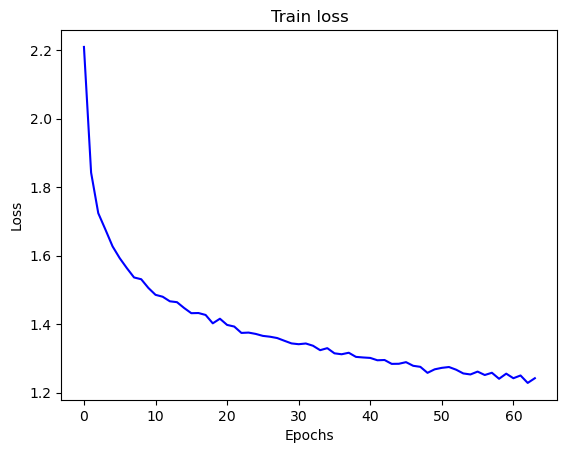

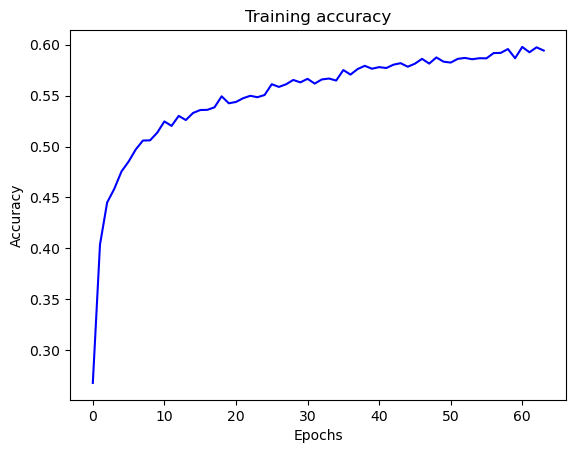

In [26]:
# fit the model on the whole training set
train_dataset, inp_shape = create_dataset(train_df, batch_s, use_keypoints=use_keypoints, use_object=use_object)

model = create_model(input_shape=inp_shape)

results = model.fit(train_dataset,
                    epochs=int(avg_epochs), verbose=0)

train_loss = results.history['loss']
train_accuracy = results.history['accuracy']

plt.plot(train_loss, 'b')
plt.title('Train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(train_accuracy, 'b')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Test 

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5808 - loss: 1.2989  
Test accuracy: 0.5635
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2024-08-22 18:46:54.785394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


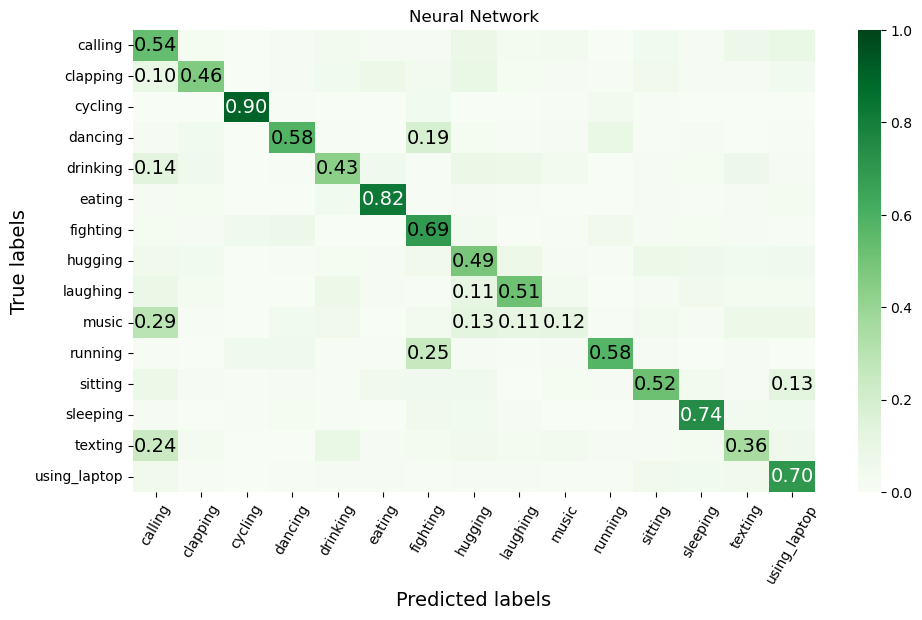

,Accuracy,Sensitivity,Specificity,Precision
calling,0.894048,0.535714,0.919643,0.322581
clapping,0.945238,0.464286,0.979592,0.619048
cycling,0.986508,0.904762,0.992347,0.894118
dancing,0.956349,0.583333,0.982993,0.710145
drinking,0.935317,0.434524,0.971088,0.517730
eating,0.971429,0.821429,0.982143,0.766667
fighting,0.927778,0.690476,0.944728,0.471545
hugging,0.915873,0.488095,0.946429,0.394231
laughing,0.941270,0.511905,0.971939,0.565789
music,0.925000,0.119048,0.982568,0.327869


In [27]:
# Evaluate the model on the test set

test_dataset, _ = create_dataset(test_df, batch_s, use_keypoints=use_keypoints, use_object=use_object)

test_loss, test_accuracy = model.evaluate(test_dataset)

print(f'Test accuracy: {test_accuracy:.4f}')

# compute predicted labels

output_vector = model.predict(test_dataset)
predicted_labels = np.argmax(output_vector[:,:], axis=1)

extracted_labels = []
for _, label in test_dataset:
    extracted_labels.extend(label.numpy().tolist())

true_labels = np.array(extracted_labels)

# compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

plot_confusion_matrix(cm)

test_metrics = class_specific_metrics(cm)
test_metrics

Accuracy = (true positive + true negative) / total

Sensitivity = true positive / (true positive + false negative)

Specificity = true negative / (true negative + false positive)

Precision = true positive / (true positive + false positive)